In [10]:
%load_ext autoreload
%autoreload 2
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
import matplotlib.pyplot as plt
import torch


import default_config
from datasets.synthetic import get_synth_immersion
from main_eval import get_model_immersion
from main_eval import compute_extrinsic_curvature
from main_eval import plot_curvature_profile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluate Synthetic Data

## From analytic form of immersion

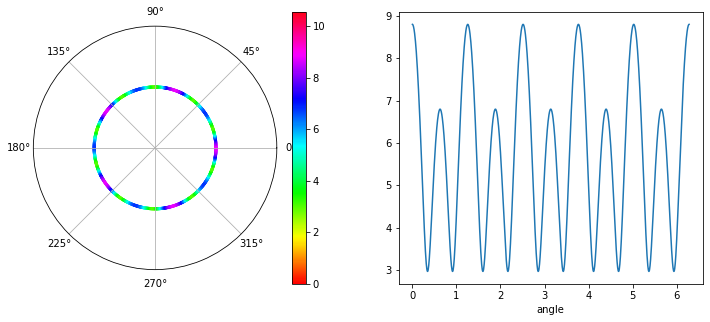

In [16]:
immersion = get_synth_immersion(radius = default_config.radius,
n_wiggles=default_config.n_wiggles,amp_wiggles=default_config.amp_wiggles,
embedding_dim=default_config.embedding_dim, rot=default_config.rot)

angles = gs.linspace(0,2*gs.pi,1000)



mean_curvature_synth, mean_curvature_norm_synth = compute_extrinsic_curvature(angles,immersion,default_config.embedding_dim)
plot_curvature_profile(angles, mean_curvature_norm_synth)

## Learned immersion via VAE

### Load model

In [12]:
model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-09-07 16:27:00_model.pt"

model = torch.load(model_filename)

### Compare reconstruction with inputs

Dataset shape: torch.Size([1000, 2]).


/Users/franciscoacosta/Desktop/code/abn/abn/datasets/utils.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_torch = torch.tensor(dataset)


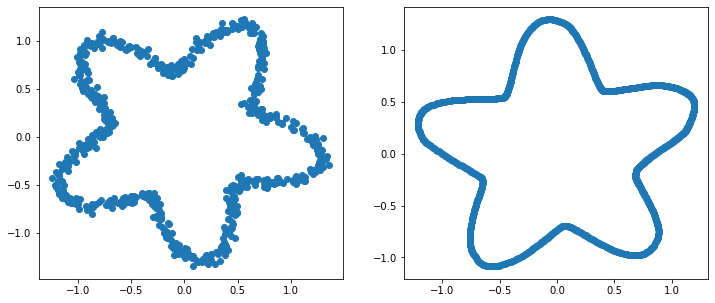

In [18]:
from datasets import utils
dataset_torch, labels, train_loader, test_loader = utils.load(default_config)

x_data = [train_loader.dataset[i][0][0] for i in range(700)]
y_data = [train_loader.dataset[i][0][1] for i in range(700)]

angles = torch.linspace(0,2*gs.pi,1000)
z = torch.stack([torch.cos(angles), torch.sin(angles)],axis=-1)

rec = model.decode(z)

x_rec = rec[0][:,0].cpu().detach().numpy()
y_rec = rec[0][:,1].cpu().detach().numpy()

plt.figure(figsize=(12,5))

ax_data = plt.subplot(1,2,1)
sc_data = ax_data.scatter(x_data,y_data)

ax_rec = plt.subplot(1,2,2)

sc_rec = ax_rec.scatter(x_rec,y_rec)

### Visualize Latent Space

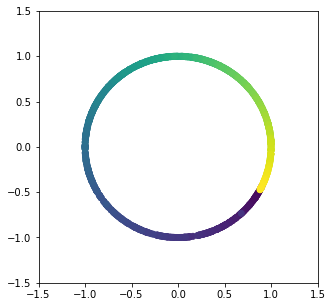

In [14]:
_, posterior_params = model(dataset_torch)

z, _, _ = model.reparameterize(posterior_params)


plt.figure(figsize=(5,5))
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

z0 = z[:,0].cpu().detach().numpy()
z1 = z[:,1].cpu().detach().numpy()

plt.scatter(z0,z1,c=labels["angles"])

### Visualize learned curvature

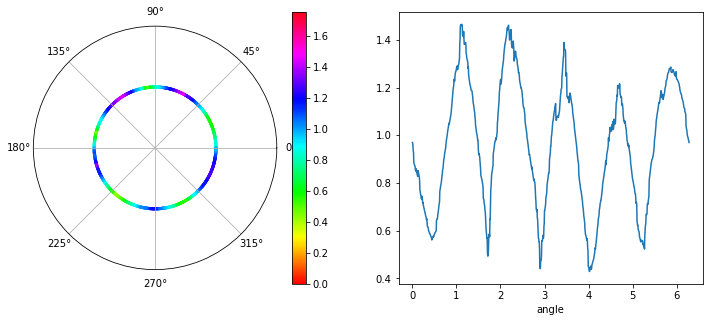

In [15]:
model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-09-08 18:20:00_model.pt"

model = torch.load(model_filename)

model.eval()

from datasets.synthetic import get_synth_immersion

angles = gs.linspace(0,2*gs.pi,1000)

immersion = get_model_immersion(model) 

mean_curvature, mean_curvature_norm = compute_extrinsic_curvature(angles,immersion,default_config.embedding_dim)

plot_curvature_profile(angles,mean_curvature_norm)

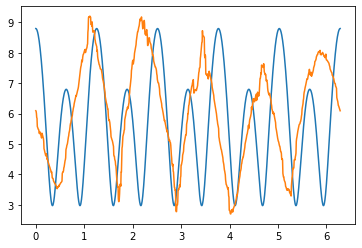

In [26]:
plt.plot(angles, mean_curvature_norm_synth)
plt.plot(angles, 2*gs.pi*mean_curvature_norm)